# CITS5014/15 Research Project

### Name: Peter Millitz [23088298]   Date: 17/10/2025

# Deep-Learning-Based Techniques for Ship Object Detection and Classification Using Complex-Valued SAR Imagery

## \[Part 2: Model Training and Evaluation\]

## 1. Modelling

### Custom Dataset Class and Image Re-sizing functions

In [12]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset

def letterbox_resize(image, labels, new_shape=640, color=(114/255, 114/255, 114/255), scaleup=True):
    """
    Resize image and bounding boxes using letterbox method.
    
    [Note: 114/255 is approx equal to 0.447 which is the padded value expected by Ultralytics.]

    Args:
        image (ndarray):   Input image with shape (C, H, W) and normalised values [0, 1].
        labels (ndarray):  Bounding boxes in normalised YOLO format (cls xc yc w h).
        color: (float:):   When padding applied to make image square, OpenCV fills the
                           border with a constant color (normalised-color value).
        scaleup (Boolean): Only applicable when images size is less than 640.
    Returns:
        image_resized (ndarray): Resized and padded image (C, H', W').
        labels (ndarray):        Adjusted normalised bounding boxes (cls xc yc w h).
    """
    h0, w0 = image.shape[:2]  # original height, width
    new_shape = (new_shape, new_shape)

    # Calculate scale ratio
    r = min(new_shape[0] / h0, new_shape[1] / w0)
    if not scaleup:
      r = min(r, 1.0)

    # Calculate new unpadded size
    new_unpad = (int(round(w0 * r)), int(round(h0 * r)))  # (width, height)

    # Calculate padding
    dw = new_shape[1] - new_unpad[0]  # width padding
    dh = new_shape[0] - new_unpad[1]  # height padding
    dw /= 2  # split equally
    dh /= 2

    # Resize image
    image_resized = cv2.resize(image, new_unpad, interpolation=cv2.INTER_LINEAR)

    # Add padding
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    image_resized = cv2.copyMakeBorder(
      image_resized, top, bottom, left, right,
      cv2.BORDER_CONSTANT, value=color
    )
        
    # Transform labels (working directly with normalised coordinates)
    if labels.size > 0:
          # Convert normalized coords to original pixel space
        labels[:, 1] *= w0  # x_center
        labels[:, 2] *= h0  # y_center  
        labels[:, 3] *= w0  # width
        labels[:, 4] *= h0  # height

        # Apply letterbox transformation
        labels[:, 1] = r * labels[:, 1] + left    # x_center
        labels[:, 2] = r * labels[:, 2] + top     # y_center
        labels[:, 3] = r * labels[:, 3]           # width
        labels[:, 4] = r * labels[:, 4]           # height

        # Normalize to new image size
        labels[:, [1, 3]] /= new_shape[1]  # normalise x, w
        labels[:, [2, 4]] /= new_shape[0]  # normalise y, h
          
    return image_resized, labels

In [13]:
# sar_dataset.py - custom Dataset class
class SARPreprocessedDataset(Dataset):
    def __init__(self, image_dir, label_dir, imgsz=640):
        self.image_paths = sorted([
            os.path.join(image_dir, fname)
            for fname in os.listdir(image_dir) if fname.endswith('.npy')
        ])
        self.label_paths = sorted([
            os.path.join(label_dir, fname.replace('_proc.npy', '.txt'))
            for fname in os.listdir(image_dir) if fname.endswith('.npy')
        ])
        self.imgsz = imgsz

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        im = np.load(self.image_paths[idx])  # (3, H, W)
        im = np.transpose(im, (1, 2, 0))      # → (H, W, 3)

        # Load labels
        label_path = self.label_paths[idx]
        if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
            labels = np.loadtxt(label_path, ndmin=2, dtype=np.float32)
        else:
            labels = np.zeros((0, 5), dtype=np.float32)
       
        # Apply letterbox resize
        im, labels = letterbox_resize(im, labels, new_shape=self.imgsz)

        # Convert back to torch format
        im = torch.from_numpy(im).permute(2, 0, 1).float().contiguous()
        labels = torch.from_numpy(labels).float()

        return im, labels


In [20]:
# Check #1 after building the data set
ds = SARPreprocessedDataset("/mnt/h/SARFish/Generated/SLC/train/crops_prc/images", "/mnt/h/SARFish/Generated/SLC/train/crops_prc/labels", imgsz=640)
img, label = ds[0]
print(f"First image in ds tensor shape: {img.shape}")   # torch.Size([3, 640, 640])
print(f"First label in ds tensor shape: {label.shape}") # (N, 5) if N objects
print(f"First label in ds tenosr form content: {label}")

First image in ds tensor shape: torch.Size([3, 640, 640])
First label in ds tensor shape: torch.Size([1, 5])
First label in ds tenosr form content: tensor([[0.0000, 0.4896, 0.5000, 0.5208, 0.1458]])


✅ image has been resized to 640 x 640 label normalised and correct 

In [21]:
# Check #2 after building the data set
for i in range(img.shape[0]):
    print(f"Channel {i}: min={img[i].min().item()}, max={img[i].max().item()}, mean={img[i].mean().item()}")

Channel 0: min=0.006087781395763159, max=1.0, mean=0.6365606784820557
Channel 1: min=1.7277152437600307e-05, max=1.0, mean=0.502548098564148
Channel 2: min=0.0, max=0.9999907612800598, mean=0.5069760084152222


✅ channel ranges are normalised.

### Visual Check

In [22]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch

def visualize_random_samples(dataset, n=5, class_names=None, seed=None):
    """
    Randomly select N samples from the dataset and visualize channel-1 magnitude with bounding boxes and labels using Matplotlib.
    Each class gets a unique color for its bounding box and label.
    
    Args:
        dataset (Dataset): Your SARPreprocessedDataset instance.
        n (int): Number of random images to visualize.
        class_names (list of str, optional): Class name list for labeling.
        seed (int, optional): Random seed for reproducibility.
    """
    if seed is not None:
        random.seed(seed)
    
    # Define colors for different classes (starting with red and lime as requested)
    colors = ['red', 'lime']
    
    indices = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(1, n, figsize=(5 * n, 5))
    if n == 1:
        axs = [axs]
    
    for ax, idx in zip(axs, indices):
        img_tensor, labels = dataset[idx]
        
        # Extract magnitude channel (channel 1)
        img_np = img_tensor[0].cpu().numpy()
        
        # Logarithmic scaling (dB conversion)
        #epsilon = np.float32(1e-6)
        #img_np = np.log10(img_np + epsilon) * np.float32(20)
        
        # Display image
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Sample {idx}")
        
        h, w = img_np.shape
        for label in labels:
            cls, xc, yc, bw, bh = label.tolist()
            cls_idx = int(cls)
            
            # Get color for this class
            color = colors[cls_idx % len(colors)]
            
            xc *= w
            yc *= h
            bw *= w
            bh *= h
            x1 = xc - bw / 2
            y1 = yc - bh / 2
            
            # Draw rectangle with class-specific color
            rect = patches.Rectangle(
                (x1, y1), bw, bh,
                linewidth=1.5,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)
            
            # Draw label with class-specific color
            if class_names:
                text = class_names[cls_idx]
                ax.text(
                    x1, y1 - 10, text,
                    fontsize=12,
                    color=color,
                    verticalalignment='bottom',
                    bbox=dict(facecolor='black', alpha=0.6, pad=1)
                )
    
    plt.tight_layout()
    plt.show()

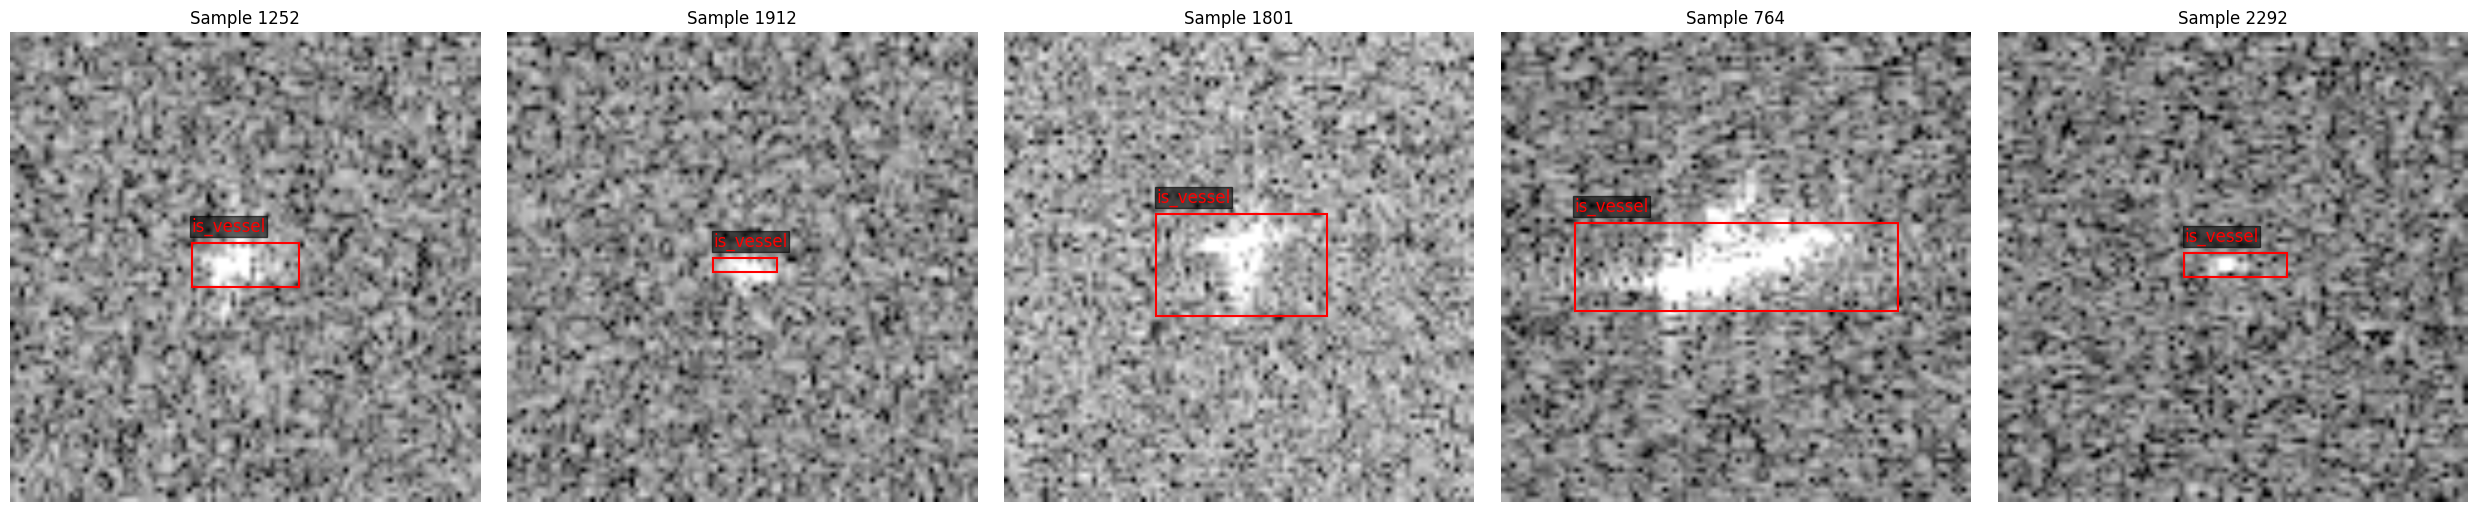

In [28]:
# Check #3 after building dataset
class_names = ['is_vessel', 'is_fishing']
visualize_random_samples(ds, n=5, class_names=class_names, seed=None)

✅ bounding boxes are correctly positioned